# Intro Task, Object Localization

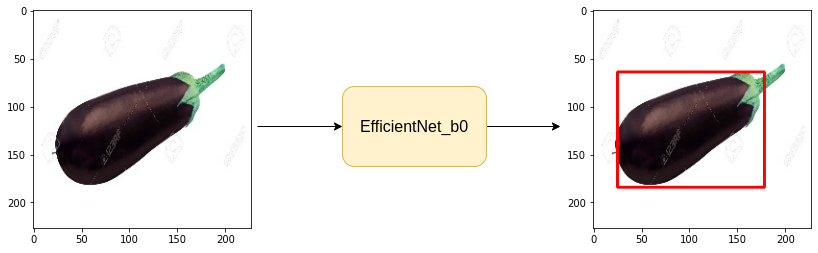

In [158]:
from networkx.algorithms.bipartite.cluster import modes
from torch.utils.data import Dataset
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-559cbp_8
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-559cbp_8
  Git user: Lukas Woodtli <lukas.woodtli@husqvarnagroup.com>
  Resolved https://github.com/albumentations-team/albumentations to commit fe249f572df79a56259f7b878a3951d79fd64b92
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [159]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [160]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [161]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [162]:
CSV_FILE = "object-localization-dataset/train.csv"
DATA_DIR = "object-localization-dataset/"

DEVICE = "cpu"

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4


In [163]:
df = pd.read_csv(CSV_FILE)


# Understand the dataset

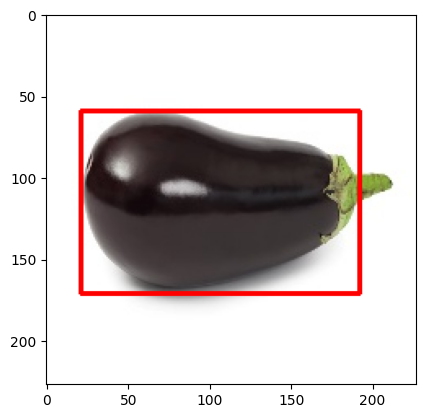

In [164]:
from pathlib import Path

row = df.loc[184]

img = cv2.imread(Path(DATA_DIR) / row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt0 = (row.xmin, row.ymin)
pt1 = (row.xmax, row.ymax)
boundig_box_img = cv2.rectangle(img, pt0, pt1, ( 255, 0, 0), 2)
plt.imshow(img)

In [165]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)


# Augmentations

In [166]:
import albumentations as A

In [167]:
train_augs = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


# Create Custom Dataset

In [168]:
class ObjLocDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax
        
        bbox = [[xmin, ymin, xmax, ymax]]
        
        img_path = Path(DATA_DIR) / row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
            img = data['image']
            bbox = data['bboxes'][0]
        
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0  # (h, w, c) -> (c, h, w)
        bbox = torch.Tensor(bbox)
        return img, bbox
        

In [169]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [170]:
print(f"Total training samples: {len(trainset)}")
print(f"Total validation samples: {len(validset)}")

Total training samples: 148
Total validation samples: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


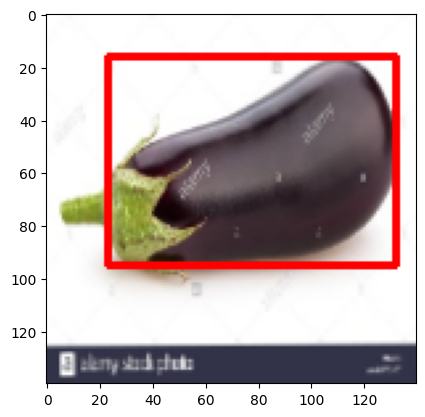

In [171]:
img, bbox = trainset[80]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [172]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [173]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [174]:
for images, bboxes in trainloader:
    break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [175]:
from torch import nn
import timm

In [176]:
class ObjLocModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)
        
    def forward(self, images, gt_bboxes=None):
        bboxes = self.backbone(images)
        
        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        
        return bboxes

In [177]:
model = ObjLocModel()
model.to(DEVICE)


ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

In [178]:
random_img = torch.rand(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [179]:
def train_fn(model, datloader, optimizer):
    total_loss = 0.0
    model.train()  # Dropout ON
    
    for data in tqdm(datloader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
        
        bboxes, loss = model(images, gt_bboxes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(datloader)
        
        

In [180]:
def eval_fn(model, datloader):
    total_loss = 0.0
    model.eval()  # Dropout OFF
    
    with torch.no_grad():
        for data in tqdm(datloader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
            
            bboxes, loss = model(images, gt_bboxes)    
           
            total_loss += loss.item()
    
        return total_loss / len(datloader)

# Training Loop

In [181]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [182]:
from tqdm import tqdm

best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("WEIGHTS-ARE-SAVED")
        best_valid_loss = valid_loss
        
    print(f"Epoch: {i + 1} train loss: {train_loss} valid loss: {valid_loss}")
    

100%|██████████| 3/3 [00:00<00:00,  8.46it/s]


WEIGHTS-ARE-SAVED
Epoch: 1 train loss: 5466.105078125 valid loss: 3697.0309244791665


100%|██████████| 3/3 [00:00<00:00,  8.04it/s]


Epoch: 2 train loss: 2053.5314086914063 valid loss: 4077.3050130208335


100%|██████████| 3/3 [00:00<00:00,  8.01it/s]


WEIGHTS-ARE-SAVED
Epoch: 3 train loss: 1101.8051452636719 valid loss: 286.07001241048175


100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


WEIGHTS-ARE-SAVED
Epoch: 4 train loss: 749.1414978027344 valid loss: 215.54009501139322


100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


WEIGHTS-ARE-SAVED
Epoch: 5 train loss: 564.1919006347656 valid loss: 157.38776652018228


100%|██████████| 3/3 [00:00<00:00,  7.48it/s]


WEIGHTS-ARE-SAVED
Epoch: 6 train loss: 415.51356201171876 valid loss: 127.53480275472005


100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


Epoch: 7 train loss: 313.27738189697266 valid loss: 148.1895014444987


100%|██████████| 3/3 [00:00<00:00,  7.37it/s]


Epoch: 8 train loss: 234.6691879272461 valid loss: 204.91907755533853


100%|██████████| 3/3 [00:00<00:00,  9.33it/s]


Epoch: 9 train loss: 180.4976013183594 valid loss: 211.94124348958334


100%|██████████| 3/3 [00:00<00:00,  8.31it/s]


Epoch: 10 train loss: 147.38769760131837 valid loss: 155.31570688883463


100%|██████████| 3/3 [00:00<00:00,  7.82it/s]


WEIGHTS-ARE-SAVED
Epoch: 11 train loss: 125.95955696105958 valid loss: 119.82878112792969


100%|██████████| 3/3 [00:00<00:00,  7.37it/s]


WEIGHTS-ARE-SAVED
Epoch: 12 train loss: 106.60914306640625 valid loss: 104.4376932779948


100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch: 13 train loss: 96.9011734008789 valid loss: 125.29946390787761


100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


Epoch: 14 train loss: 110.70549926757812 valid loss: 116.97814432779948


100%|██████████| 3/3 [00:00<00:00,  8.09it/s]


Epoch: 15 train loss: 78.75971984863281 valid loss: 112.50324249267578


100%|██████████| 3/3 [00:00<00:00,  7.71it/s]


Epoch: 16 train loss: 93.38170547485352 valid loss: 128.5988286336263


100%|██████████| 3/3 [00:00<00:00,  8.62it/s]


Epoch: 17 train loss: 81.70378837585449 valid loss: 114.29052480061848


100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Epoch: 18 train loss: 71.05102157592773 valid loss: 117.46044413248698


100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


WEIGHTS-ARE-SAVED
Epoch: 19 train loss: 65.46992282867431 valid loss: 99.68593851725261


100%|██████████| 3/3 [00:00<00:00,  7.99it/s]


WEIGHTS-ARE-SAVED
Epoch: 20 train loss: 49.79677810668945 valid loss: 87.68477121988933


100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


WEIGHTS-ARE-SAVED
Epoch: 21 train loss: 61.47204742431641 valid loss: 71.400697072347


100%|██████████| 3/3 [00:00<00:00,  8.45it/s]


WEIGHTS-ARE-SAVED
Epoch: 22 train loss: 47.697299575805665 valid loss: 63.95893478393555


100%|██████████| 3/3 [00:00<00:00,  8.48it/s]


Epoch: 23 train loss: 64.36818084716796 valid loss: 97.33646774291992


100%|██████████| 3/3 [00:00<00:00,  8.94it/s]


Epoch: 24 train loss: 45.250664138793944 valid loss: 94.48651885986328


100%|██████████| 3/3 [00:00<00:00,  7.29it/s]


Epoch: 25 train loss: 54.004917526245116 valid loss: 68.22422409057617


100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


WEIGHTS-ARE-SAVED
Epoch: 26 train loss: 46.80133323669433 valid loss: 58.46109390258789


100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


Epoch: 27 train loss: 44.885699081420896 valid loss: 64.34688059488933


100%|██████████| 3/3 [00:00<00:00,  7.83it/s]


Epoch: 28 train loss: 44.446373748779294 valid loss: 64.11141713460286


100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


Epoch: 29 train loss: 46.18230056762695 valid loss: 74.630064646403


100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Epoch: 30 train loss: 49.08339424133301 valid loss: 105.70082346598308


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Epoch: 31 train loss: 49.85640449523926 valid loss: 86.29264958699544


100%|██████████| 3/3 [00:00<00:00,  7.49it/s]


Epoch: 32 train loss: 40.06149806976318 valid loss: 76.20345942179362


100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


WEIGHTS-ARE-SAVED
Epoch: 33 train loss: 38.38829803466797 valid loss: 53.50594711303711


100%|██████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch: 34 train loss: 38.12799491882324 valid loss: 71.86766560872395


100%|██████████| 3/3 [00:00<00:00,  7.39it/s]


Epoch: 35 train loss: 44.73589897155762 valid loss: 55.285910288492836


100%|██████████| 3/3 [00:00<00:00,  5.79it/s]


Epoch: 36 train loss: 34.264601421356204 valid loss: 77.73856862386067


100%|██████████| 3/3 [00:00<00:00,  9.64it/s]


Epoch: 37 train loss: 37.51756038665771 valid loss: 54.279927571614586


100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


Epoch: 38 train loss: 37.82980880737305 valid loss: 64.53826395670573


100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch: 39 train loss: 62.643524932861325 valid loss: 83.80947240193684


100%|██████████| 3/3 [00:00<00:00,  7.72it/s]

Epoch: 40 train loss: 39.3151138305664 valid loss: 93.96092351277669


# Inference

In [184]:
import utils


/tmp/ipykernel_96817/3339993871.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
Clipping input data to the valid range

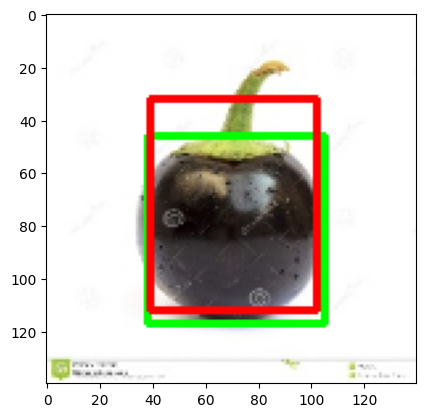

In [190]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    example_no = 20  # change for showing different images with true and predicted bounded box
    image, gt_bbox = validset[example_no]  # (c, h, w)
    image = image.unsqueeze(0).to(DEVICE)  # (batch, c, h, w)
    out_bbox = model(image)
    
    utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya